# ASTERDEM

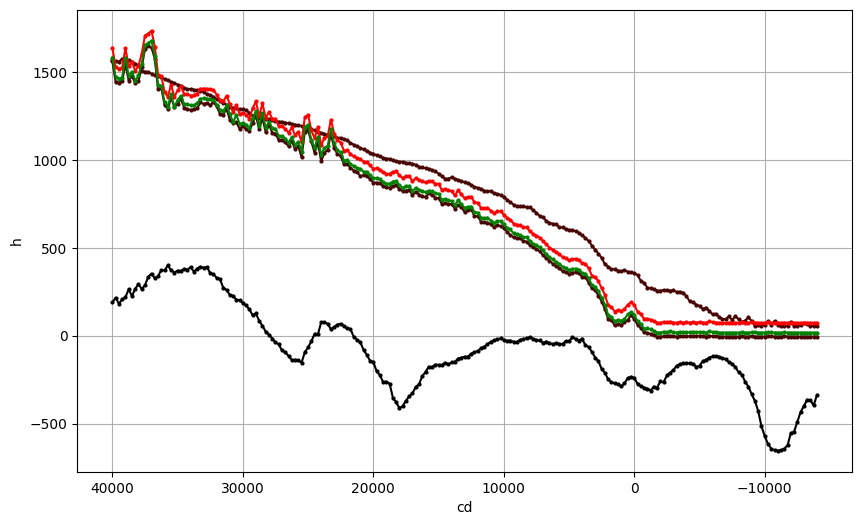

In [45]:
import xarray as xr
import rioxarray
import geopandas as gpd
import pandas as pd
import numpy as np

GLACIER = "UI"

# Load the points from the .geojson file
geojson_path = "../data/misc/centreline_points.geojson"
points_gdf = gpd.read_file(geojson_path)
points_gdf = points_gdf.sort_values(by=["cd"]).reset_index()
points_gdf = points_gdf[points_gdf["glacier_code"] == GLACIER]
points_gdf = points_gdf[points_gdf["cd"] <= 40000]


asterdem = "../.scratch/AST14DMO_00308192023132719_20240603063558_1329776/AST14DMO_00308192023132719_20240603063558_1329776_DEM.tif"
asterdem = rioxarray.open_rasterio(asterdem)
points_gdf = points_gdf.to_crs(asterdem.rio.crs)
coords = np.array([(geom.x, geom.y) for geom in points_gdf.geometry])
xs, ys = coords[:, 0], coords[:, 1]
asterdem_sampled = asterdem.sel(
    x=xr.DataArray(xs, dims="points"), y=xr.DataArray(ys, dims="points"), method="nearest"
).values
points_gdf["asterdem"] = asterdem_sampled.flatten()

asterdem2 = "../data/elevation/arcticdem/ui/AST14DMO_00308192023132719_20240603063558_1329776_DEM_coreg_resamp.tif"
asterdem2 = rioxarray.open_rasterio(asterdem2)
points_gdf = points_gdf.to_crs(asterdem2.rio.crs)
coords = np.array([(geom.x, geom.y) for geom in points_gdf.geometry])
xs, ys = coords[:, 0], coords[:, 1]
asterdem2_sampled = asterdem2.sel(
    x=xr.DataArray(xs, dims="points"), y=xr.DataArray(ys, dims="points"), method="nearest"
).values
points_gdf["asterdem2"] = asterdem2_sampled.flatten()

asterdem3 = "../data/elevation/arcticdem/ui/AST14DMO_00308192023132719_20240603063558_1329776_DEM_coreg_resamp_2.tif"
asterdem3 = rioxarray.open_rasterio(asterdem3)
points_gdf = points_gdf.to_crs(asterdem3.rio.crs)
coords = np.array([(geom.x, geom.y) for geom in points_gdf.geometry])
xs, ys = coords[:, 0], coords[:, 1]
asterdem3_sampled = asterdem3.sel(
    x=xr.DataArray(xs, dims="points"), y=xr.DataArray(ys, dims="points"), method="nearest"
).values
points_gdf["asterdem3"] = asterdem3_sampled.flatten()

bedmachine = "../data/misc/bedmachine/BedMachineGreenland-v5.nc"
bedmachine = xr.open_dataset(bedmachine)
coords = np.array([(geom.x, geom.y) for geom in points_gdf.geometry])
bedmachine_sampled = (
    bedmachine["bed"]
    .sel(
        x=xr.DataArray(xs, dims="points"), y=xr.DataArray(ys, dims="points"), method="nearest"
    )
    .values
)
points_gdf["bed"] = bedmachine_sampled

aerodem = (
    "../data/elevation/aerodem/aerodem_1981_utm25.tif"
    if GLACIER == "UI"
    else "../data/elevation/aerodem/aerodem_1987_utm26_3.tif"
)
aerodem = rioxarray.open_rasterio(aerodem)
points_gdf = points_gdf.to_crs(aerodem.rio.crs)
coords = np.array([(geom.x, geom.y) for geom in points_gdf.geometry])
xs, ys = coords[:, 0], coords[:, 1]
areodem_sampled = aerodem.sel(
    x=xr.DataArray(xs, dims="points"), y=xr.DataArray(ys, dims="points"), method="nearest"
).values
points_gdf["aerodem"] = areodem_sampled.flatten()


grimpdem_1 = (
    "../data/elevation/grimpdem/gimpdem4_2_v01.1.tif"
    if GLACIER == "UI"
    else "../data/elevation/grimpdem/gimpdem4_3_v01.1.tif"
)
grimpdem_1 = rioxarray.open_rasterio(grimpdem_1)
points_gdf = points_gdf.to_crs(grimpdem_1.rio.crs)
coords = np.array([(geom.x, geom.y) for geom in points_gdf.geometry])
xs, ys = coords[:, 0], coords[:, 1]
grimpdem_1_sampled = grimpdem_1.sel(
    x=xr.DataArray(xs, dims="points"), y=xr.DataArray(ys, dims="points"), method="nearest"
).values
points_gdf["grimpdem_1"] = grimpdem_1_sampled.flatten()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(
    points_gdf["cd"],
    points_gdf["aerodem"],
    c="#490404",
    marker="o",
    # linestyle="",
    markersize=2,
)
plt.plot(
    points_gdf["cd"],
    points_gdf["asterdem"],
    c="#490404",
    marker="o",
    # linestyle="",
    markersize=2,
)
plt.plot(
    points_gdf["cd"],
    points_gdf["asterdem2"],
    c="red",
    marker="o",
    # linestyle="",
    markersize=2,
)
plt.plot(
    points_gdf["cd"],
    points_gdf["asterdem3"],
    c="green",
    marker="o",
    # linestyle="",
    markersize=2,
)
plt.plot(
    points_gdf["cd"],
    points_gdf["bed"],
    c="black",
    marker="o",
    # linestyle="",
    markersize=2,
)

plt.xlabel("cd")
plt.ylabel("h")
# plt.xlim(-1000, 5000)
# plt.ylim(0, 500)
plt.grid(True)
plt.gca().invert_xaxis()
plt.show()

In [36]:
"""
This script automatically downloads and coregisters a complete history of ArcticDEM or
REMA strips within a given AOI. The strips will be created within a named directory in 
the current working directory.

The script will download the 2 m ArcticDEM or REMA mosaic for coregistration, and then
loop through the strip record, downloading and coregistering against stable ground
identified within the BedMachine mask.

Note: this will only work in regions of Greenland and Antarctica where bare rock
is exposed. If you require coregistration in other regions, please drop me an email - 
I would be happy to help.

Tom Chudley | thomas.r.chudley@durham.ac.uk
Durham University
November 2023
"""
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pdemtools as pdt
import rioxarray as rxr
import xarray as xr
from rasterio.enums import Resampling

# ----------------------------------------------------------------------------------- #
# EDIT THIS SECTION TO SPECIFY DEPENDENT FILES, THE REGION, AND BOUNDS OF INTEREST
# ----------------------------------------------------------------------------------- #

# Filepath to BedMachine v5 netcdf file
bm_fpath = "../data/misc/bedmachine/BedMachineGreenland-v5.nc"
region = "ui"
resolution = 2

points = gpd.read_file("../data/misc/centreline_points.geojson")
points = points.sort_values(by=["glacier_code", "cd"])
points = points[points["cd"].between(-15000, 40000)]
points = points[points["glacier_code"] == "UI"].reset_index()

xmin, ymin, xmax, ymax = points.total_bounds
bounds = (xmin, ymin, xmax, ymax)

outdir = f"../data/elevation/arcticdem/{region}"
reference_dem_fpath = os.path.join(outdir, f"{region}_arcticdem_mosaic_{resolution}m.tif")

reference_dem = pdt.load.from_fpath(
    os.path.join(outdir, f"{region}_arcticdem_mosaic_{resolution}m.tif"), bounds=bounds
)
reference_dem = reference_dem.squeeze()
reference_dem = reference_dem.rio.reproject(
    reference_dem.rio.crs,
    resolution=(30, 30),
    resampling=Resampling.bilinear,
)

bedrock_mask = pdt.data.bedrock_mask_from_bedmachine(bm_fpath, reference_dem)
bedrock_mask = bedrock_mask.rio.reproject_match(reference_dem, resampling=Resampling.nearest)

geoid = pdt.data.geoid_from_bedmachine(bm_fpath, reference_dem)
# reference_dem = reference_dem.pdt.geoid_correct(geoid)

C:\Users\olive\AppData\Roaming\Python\Python311\site-packages\rioxarray\raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


In [44]:
out_fpath = os.path.join(
    outdir,
    f"AST14DMO_00308192023132719_20240603063558_1329776_DEM_coreg_resamp_2.tif",
)

asterdem = "../.scratch/AST14DMO_00308192023132719_20240603063558_1329776/AST14DMO_00308192023132719_20240603063558_1329776_DEM.tif"

dem = pdt.load.from_fpath(asterdem, bounds=bounds, reproject=True)
dem = dem.rio.reproject_match(reference_dem, resampling=Resampling.bilinear, nodata=np.nan)
dem = dem.pdt.coregister(reference_dem, bedrock_mask, max_horiz_offset=50)

if not os.path.exists(out_fpath):
    print(f"\nSaving {os.path.basename(out_fpath)}...")
    dem.rio.to_raster(out_fpath, compress="ZSTD", predictor=3, zlevel=1)

Planimetric Correction Iteration 1
Offset (z,x,y): 0.000, 0.000, 0.000
RMSE = 134.29632568359375
Planimetric Correction Iteration 2
Offset (z,x,y): -55.270, 27.716, -15.825
Translating: -55.27 Z, 27.72 X, -15.83 Y
RMSE = 78.16815185546875
Planimetric Correction Iteration 3
Offset (z,x,y): -40.726, 45.330, -5.326
Translating: -40.73 Z, 45.33 X, -5.33 Y
RMSE = 74.7522201538086
Planimetric Correction Iteration 4
Offset (z,x,y): -41.109, 52.916, -0.799
Maximum horizontal offset (50) exceeded.Consider raising the threshold if offsets are large.
Returning median vertical offset: -22.677
Final offset (z,x,y): -22.677, 0.000, 0.000
Final RMSE = 127.21183776855469

Saving AST14DMO_00308192023132719_20240603063558_1329776_DEM_coreg_resamp_2.tif...


# PRODEM

In [35]:
import glob

import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr


points = gpd.read_file("../data/misc/centreline_points.geojson")
points = points.sort_values(by=["glacier_code", "cd"])
points = points[points["cd"].between(-15000, 40000)].reset_index()

files = glob.glob("../data/elevation/prodem/*.tif")

prodem_results = xr.Dataset(
    data_vars={
        "h_median": (("cd", "date"), np.empty((len(points.cd), len(files)))),
    },
    coords={
        "x": (("cd",), points.geometry.x),
        "y": (("cd",), points.geometry.y),
        "cd": (("cd",), points.cd),
        "glacier_code": (("cd",), points.glacier_code),
    },
)

# Stack mosaics by year into lazy dask dataset
dems = xr.open_mfdataset(files, concat_dim="year", combine="nested")

# To temporarily store pre-concatenated sampled DataSets
results = []

# Group points by glacier
for glacier, points_glacier in points.groupby(by="glacier_code"):
    # Create new coord lists for bounds of 1 km box about each point
    box_size = 1000
    half_box = box_size / 2
    x_mins = points_glacier.geometry.x.values - half_box
    x_maxs = points_glacier.geometry.x.values + half_box
    y_mins = points_glacier.geometry.y.values - half_box
    y_maxs = points_glacier.geometry.y.values + half_box

    # Iterate over each point for current glacier
    for i, point in points_glacier.reset_index().iterrows():
        # Define slices for x and y bounds of sampling box
        x_slice = slice(x_mins[i], x_maxs[i])
        y_slice = slice(y_maxs[i], y_mins[i])

        # Subset dataset by box
        subset = dems.sel(band=1, x=x_slice, y=y_slice)

        # Lazily sample median v and v_error
        subset["band_data"] = subset.band_data.median(
            dim=["x", "y"]
        )  # .assign_attrs(ATTRS["v"])

        # Assign dimension (glacier_code, cd) of current point
        subset = subset.drop_dims(drop_dims=["x", "y"])
        subset = subset.expand_dims(dim=["glacier_code", "cd"])
        subset = subset.assign_coords(
            glacier_code=("glacier_code", [point.glacier_code]),  # ATTRS["glacier_code"]),
            cd=("cd", [point.cd]),  # , ATTRS["cd"]),
            year=("year", [pd.to_datetime(i + 2019, format="%Y") for i in subset.year.values]),
        )
        results.append(subset)

# Concat collected results into Dataset
prodem_results = xr.combine_by_coords(results)

# Assign x and y coords for each point
points = points.set_index(["glacier_code", "cd"])
x_coords = points.geometry.x.unstack().values
y_coords = points.geometry.y.unstack().values
prodem_results = prodem_results.assign_coords(
    x=(("glacier_code", "cd"), x_coords),  # , ATTRS["x"]),
    y=(("glacier_code", "cd"), y_coords),  # ATTRS["y"]),
)

# # Optionally write results to disk
# prodem_results.to_netcdf("../data/velocity/velocity_points_annual_1985_2022.nc")

prodem_results

<xarray.Dataset>
Dimensions:       (glacier_code: 2, year: 4, cd: 217)
Coordinates:
  * glacier_code  (glacier_code) <U2 'DJ' 'UI'
  * year          (year) datetime64[ns] 2019-01-01 2020-01-01 ... 2022-01-01
  * cd            (cd) int32 -14000 -13750 -13500 -13250 ... 39500 39750 40000
    band          int32 1
    spatial_ref   int32 0
    x             (glacier_code, cd) float64 nan nan nan ... 4.566e+05 4.564e+05
    y             (glacier_code, cd) float64 nan nan ... -2.445e+06 -2.445e+06
Data variables:
    band_data     (glacier_code, cd, year) float64 dask.array<chunksize=(1, 1, 4), meta=np.ndarray>

# Centreline plot

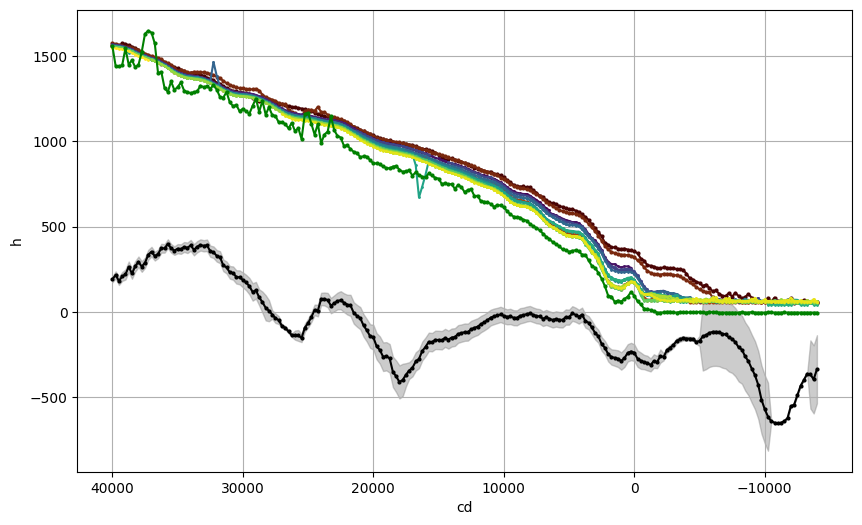

In [50]:
import xarray as xr
import rioxarray
import geopandas as gpd
import pandas as pd
import numpy as np

GLACIER = "UI"


# Load the points from the .geojson file
geojson_path = "../data/misc/centreline_points.geojson"
points_gdf = gpd.read_file(geojson_path)
points_gdf = points_gdf.sort_values(by=["cd"]).reset_index()
points_gdf = points_gdf[points_gdf["glacier_code"] == GLACIER]
points_gdf = points_gdf[points_gdf["cd"] <= 40000]


aerodem = (
    "../data/elevation/aerodem/aerodem_1981_utm25.tif"
    if GLACIER == "UI"
    else "../data/elevation/aerodem/aerodem_1987_utm26_3.tif"
)
aerodem = rioxarray.open_rasterio(aerodem)
points_gdf = points_gdf.to_crs(aerodem.rio.crs)
coords = np.array([(geom.x, geom.y) for geom in points_gdf.geometry])
xs, ys = coords[:, 0], coords[:, 1]
areodem_sampled = aerodem.sel(
    x=xr.DataArray(xs, dims="points"), y=xr.DataArray(ys, dims="points"), method="nearest"
).values
points_gdf["aerodem"] = areodem_sampled.flatten()


grimpdem_1 = (
    "../data/elevation/grimpdem/gimpdem4_2_v01.1.tif"
    if GLACIER == "UI"
    else "../data/elevation/grimpdem/gimpdem4_3_v01.1.tif"
)
grimpdem_1 = rioxarray.open_rasterio(grimpdem_1)
points_gdf = points_gdf.to_crs(grimpdem_1.rio.crs)
coords = np.array([(geom.x, geom.y) for geom in points_gdf.geometry])
xs, ys = coords[:, 0], coords[:, 1]
grimpdem_1_sampled = grimpdem_1.sel(
    x=xr.DataArray(xs, dims="points"), y=xr.DataArray(ys, dims="points"), method="nearest"
).values
points_gdf["grimpdem_1"] = grimpdem_1_sampled.flatten()

grimpdem_2 = (
    "../data/elevation/grimpdem/tile_4_2_30m_dem_v02.0.tif"
    if GLACIER == "UI"
    else "../data/elevation/grimpdem/tile_4_3_30m_dem_v02.0.tif"
)
grimpdem_2 = rioxarray.open_rasterio(grimpdem_2)
points_gdf = points_gdf.to_crs(grimpdem_2.rio.crs)
coords = np.array([(geom.x, geom.y) for geom in points_gdf.geometry])
xs, ys = coords[:, 0], coords[:, 1]
grimpdem_2_sampled = grimpdem_2.sel(
    x=xr.DataArray(xs, dims="points"), y=xr.DataArray(ys, dims="points"), method="nearest"
).values
points_gdf["grimpdem_2"] = grimpdem_2_sampled.flatten()


bedmachine = "../data/misc/bedmachine/BedMachineGreenland-v5.nc"
bedmachine = xr.open_dataset(bedmachine)
coords = np.array([(geom.x, geom.y) for geom in points_gdf.geometry])
bedmachine_sampled = (
    bedmachine["bed"]
    .sel(
        x=xr.DataArray(xs, dims="points"), y=xr.DataArray(ys, dims="points"), method="nearest"
    )
    .values
)
points_gdf["bed"] = bedmachine_sampled

bedmachine_sampled_err = (
    bedmachine["errbed"]
    .sel(
        x=xr.DataArray(xs, dims="points"), y=xr.DataArray(ys, dims="points"), method="nearest"
    )
    .values
)
points_gdf["errbed"] = bedmachine_sampled_err

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(
    points_gdf["cd"],
    points_gdf["aerodem"],
    c="#490404",
    marker="o",
    # linestyle="",
    markersize=2,
)
plt.plot(
    points_gdf["cd"],
    points_gdf["grimpdem_1"],
    c="#79280e",
    marker="o",
    # linestyle="",
    markersize=2,
)
plt.plot(
    points_gdf["cd"],
    points_gdf["grimpdem_2"],
    c="#a14812",
    marker="o",
    # linestyle="",
    markersize=2,
)
plt.plot(
    points_gdf["cd"],
    points_gdf["bed"],
    c="black",
    marker="o",
    # linestyle="",
    markersize=2,
)
plt.fill_between(
    points_gdf["cd"],
    points_gdf["bed"] - points_gdf["errbed"],
    points_gdf["bed"] + points_gdf["errbed"],
    color="grey",
    alpha=0.4,
)
# cs = ["#c1670f", "#db8706", "#f0a700", "#ffc800"]
# for i, year in enumerate(prodem_results.year):
#     h = prodem_results.band_data.sel(year=year, glacier_code=GLACIER)

#     plt.plot(h.cd.values, h.values, marker="o", c=cs[i], markersize=1)

arcticdem_results = xr.open_dataset(
    f"../data/elevation/arcticdem/{GLACIER.lower()}_arcticdem_points.nc"
)
arcticdem_results.load()

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.cm import viridis
from matplotlib.colors import Normalize

years = set(arcticdem_results.date.dt.year.values)
date_values = mdates.date2num(arcticdem_results.date.values)
norm = Normalize(vmin=np.min(date_values), vmax=np.max(date_values))
cmap = viridis

for date, date_value in zip(arcticdem_results.date.values, date_values):
    h = arcticdem_results.h_median.sel(date=date).squeeze()

    color_value = norm(date_value)
    color = cmap(color_value)
    plt.plot(arcticdem_results.cd.values, h.values, color=color, marker="o", markersize=1)

asterdem3 = "../data/elevation/arcticdem/ui/AST14DMO_00308192023132719_20240603063558_1329776_DEM_coreg_resamp.tif"
asterdem = "../.scratch/AST14DMO_00308192023132719_20240603063558_1329776/AST14DMO_00308192023132719_20240603063558_1329776_DEM.tif"
asterdem3 = rioxarray.open_rasterio(asterdem3)
points_gdf = points_gdf.to_crs(asterdem3.rio.crs)
coords = np.array([(geom.x, geom.y) for geom in points_gdf.geometry])
xs, ys = coords[:, 0], coords[:, 1]
asterdem3_sampled = asterdem3.sel(
    x=xr.DataArray(xs, dims="points"), y=xr.DataArray(ys, dims="points"), method="nearest"
).values
points_gdf["asterdem3"] = asterdem3_sampled.flatten()
plt.plot(
    points_gdf["cd"],
    points_gdf["asterdem3"],
    c="green",
    marker="o",
    # linestyle="",
    markersize=2,
)

plt.xlabel("cd")
plt.ylabel("h")
# plt.xlim(-1000, 5000)
# plt.ylim(0, 500)
plt.grid(True)
plt.gca().invert_xaxis()
plt.show()

# CryoTEMPO-EOLIS

EOLIS elevation data generated using swath processing of CryoSat data [(Gourmelen, N., Escorihuela, M., Shepherd, A., Foresta, L., Muir, A., Garcia-Mondejar, A., Roca, M., Baker, S., & Drinkwater, M. R. (2018))](https://doi.org/10.1016/j.asr.2017.11.014) and provided by the [ESA CryoTEMPO project](https://cryotempo-eolis.org/)

data downloaded from [cs2eo](https://cs2eo.org/) using [this search query](https://cs2eo.org/search?searchMode=single-polygon&productA=TEMPO_SWATH_GRID&polygon=[[-50.35,64.23],[-49.1,64.25],[-49.03,63.71],[-50.26,63.67],[-50.35,64.23]]&startDate=2010-01-01&startTime=00:00&endDate=2023-01-01&endTime=00:00&trackSpacing=100&batchRequest=false)
the `.csv` file generated from this is saved in `../data/sec/cryosat/`. This contains links to individual .nc files which can be downloaded with the below code.

In [ ]:
import json
from pathlib import Path

import ee
import geopandas as gpd
import numpy as np
import pandas as pd
import s3fs as s3
import xarray as xr
from shapely import LineString, Point
from shapely.ops import split
from scipy import stats

# only needs running if you need to download the files
path = "../data/sec/cryosat/"  # where to save the files / where the .csv file is
# path = glob(path+'*.csv')
# files = pd.read_csv(path[0])

# from ftplib import FTP
# password = 'ed.holt@ed.ac.uk'
# ftp = FTP('science-pds.cryosat.esa.int')
# ftp.login('anonymous',password)

# for product_path in tqdm(files['TEMPO_SWATH_GRID product path']):
#     path, file = os.path.split(product_path)
#     ftp.cwd(path)
#     with open(path+file, 'wb') as f:
#         ftp.retrbinary('RETR ' + file, f.write)

In [ ]:
ps = gpd.read_feather("../data/samplePoints_feather")
path = "../data/sec/cryosat/"  # where files are saved
cs_files = glob(path + "*.nc")

# read in stack of .nc files, add projection and convert time datetime
cs = xr.open_mfdataset(cs_files)  # cs means cryosat
cs = cs["elevation"].transpose("time", "y", "x").rio.write_crs("epsg:3413")

cs["time"] = pd.to_datetime(cs["time"], unit="s")

# get query points
xquery = ps.set_index(["glacier", "cd"])["x"].to_xarray()
yquery = ps.set_index(["glacier", "cd"])["y"].to_xarray()

# sample stack of .nc files, compute dask-chunks, and convert to dataframe
cs_sample = cs.sel(x=xquery, y=yquery, method="nearest")
cs_sample = xr.where(~(xquery.isnull()), cs_sample, np.nan).rename(
    "elevation"
)  # .to_dataframe()

cs_df = cs_sample.compute().to_dataframe().reset_index().dropna()

# add a years since earliest date for use in linear regression
cs_df["years"] = (cs_df["time"] - cs_df["time"].min()) / pd.Timedelta("365.25D")

# removing points along centreline where there are too few measurements
# measurements are not spaced far enough apart in time.
# needed because different time steps have different coverage
cs_date_range = cs_df.groupby(["glacier", "cd"])["years"].agg(np.ptp)
mean, std = cs_date_range.agg(["mean", "std"])
cs_df = cs_df.set_index(["glacier", "cd"]).loc[cs_date_range > (mean - std)].reset_index()

# linear regression for each point along each glacier centreline
cs_slopes = (
    cs_df.groupby(["glacier", "cd"])
    .apply(lambda q: pd.Series(stats.linregress(x=q["years"], y=q["elevation"])))
    .reset_index()
    .rename(columns={0: "slope", 1: "intercept", 2: "rvalue", 3: "pvalue", 4: "stderr"})
)

cs_slopes["Source"] = "CryoTEMPO-EOLIS"
cs_slopes[
    "Source:Period"
] = f'CryoTEMPO-EOLIS: {cs_df["time"].min().strftime("%b %Y")}-{cs_df["time"].max().strftime("%b %Y")}'

# ICESat-2 ATL15

In [67]:
from scipy import stats

ps = gpd.read_file("../data/misc/centreline_points.geojson")
ps = ps.sort_values(by=["glacier_code", "cd"]).reset_index()

atl15_file = "../data/elevation/icesat2/ATL15_GL_0318_01km_003_01.nc"
atl15 = xr.open_dataset(
    atl15_file, group="delta_h", chunks={"x": "auto", "y": "auto"}
).rio.write_crs(3413)

xquery = ps.set_index(["glacier_code", "cd"]).geometry.x.to_xarray()
yquery = ps.set_index(["glacier_code", "cd"]).geometry.y.to_xarray()

atl_sampled = atl15.sel(x=xquery, y=yquery, method="nearest")
atl_sampled = xr.where(~(xquery.isnull()), atl_sampled, np.nan)

# Compute years and days
time_min = atl_sampled.time.min().values
time_delta = (atl_sampled.time - time_min) / np.timedelta64(1, "D")  # Convert to days
years = time_delta / 365.25  # Convert days to years as float

# Combine years and days into a single coordinate
atl_sampled["years"] = xr.DataArray(years, dims="time")

atl_sampled = atl_sampled.compute()

# # slope, intercept, rvalue, pvalue, stderr
# atl_slopes = xr.apply_ufunc(
#     lambda x, y: np.array(stats.linregress(x, y)),
#     atl_sampled["years"],
#     atl_sampled["delta_h"],
#     input_core_dims=[["time"], ["time"]],
#     output_core_dims=[["stats"]],
#     vectorize=True,
# )

atl_sampled["Source"] = "IceSat-2 ATL15"
atl_sampled[
    "Source:Period"
] = f"ICESat-2 ATL15: {atl_sampled.time.min().values.astype('datetime64[D]')}-{atl_sampled.time.max().values.astype('datetime64[D]')}"

[  2.9646606    3.746643     5.581604     0.01245117  -0.8199463
   0.          -0.19000244  -3.2131958   -5.2870483   -4.6835327
  -3.918457    -6.9092407   -9.627563    -8.751831    -7.38208
  -9.910645   -11.523132    -9.41803     -9.526123  ]


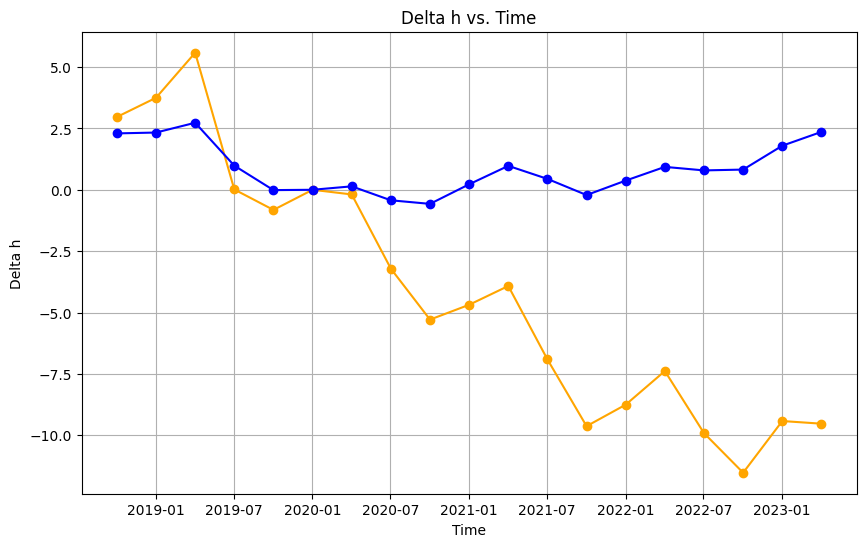

In [68]:
import pandas as pd
import matplotlib.pyplot as plt

filtered = atl_sampled.sel(cd=10000)
filtered["time"] = pd.to_datetime(filtered["time"])

plt.figure(figsize=(10, 6))

filtered_df_ui = filtered.sel(glacier_code="UI")
print(filtered_df_ui["delta_h"].values)
plt.plot(filtered_df_ui["time"], filtered_df_ui["delta_h"], marker="o", c="orange")

filtered_df_dj = filtered.sel(glacier_code="DJ")
plt.plot(filtered_df_dj["time"], filtered_df_dj["delta_h"], marker="o", c="blue")


plt.title("Delta h vs. Time")
plt.xlabel("Time")
plt.ylabel("Delta h")
plt.grid(True)
plt.show()

2018-10-01T22:30:00.000000000
2019-01-01T06:00:00.000000000
2019-04-02T13:30:00.000000000
2019-07-02T21:00:00.000000000
2019-10-02T04:30:00.000000000
2020-01-01T12:00:00.000000000
2020-04-01T19:30:00.000000000
2020-07-02T03:00:00.000000000
2020-10-01T10:30:00.000000000
2020-12-31T18:00:00.000000000
2021-04-02T01:30:00.000000000
2021-07-02T09:00:00.000000000
2021-10-01T16:30:00.000000000
2022-01-01T00:00:00.000000000
2022-04-02T07:30:00.000000000
2022-07-02T15:00:00.000000000
2022-10-01T22:30:00.000000000
2023-01-01T06:00:00.000000000
2023-04-02T13:30:00.000000000


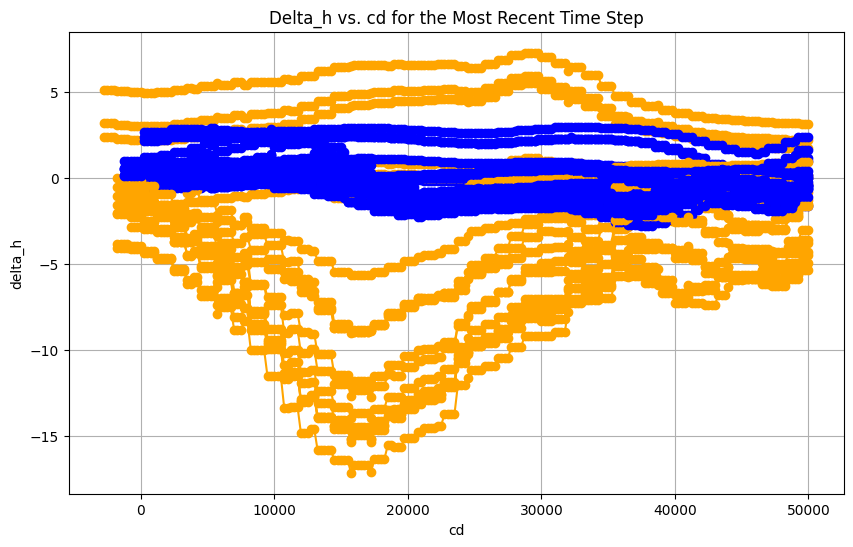

In [69]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import matplotlib.colorbar as colorbar

# Select the most recent time step
recent_time_step = atl_sampled["time"]
filtered["time"] = pd.to_datetime(filtered["time"])

plt.figure(figsize=(10, 6))

# Define colormap and normalization


for i, time_step in enumerate(recent_time_step):
    print(time_step.values)
    recent = atl_sampled.sel(time=time_step)

    filtered_df_ui = recent.sel(glacier_code="UI")
    plt.plot(
        filtered_df_ui["cd"],
        filtered_df_ui["delta_h"],
        marker="o",
        label=time_step,
        c="orange",
    )

    filtered_df_dj = recent.sel(glacier_code="DJ")
    plt.plot(
        filtered_df_dj["cd"], filtered_df_dj["delta_h"], marker="o", label=time_step, c="blue"
    )

# Plot delta_h against cd
plt.xlabel("cd")
plt.ylabel("delta_h")
# plt.legend()
plt.grid(True)
plt.show()

# ArcticDEM

In [ ]:
# set filter options

# load points

# for glacier in glaciers

# get/load arcticdem mosaic (32 m)
# load bedmachine

# search for strips

## UI

In [150]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 229 entries, 253835 to 0
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   fid                           228 non-null    float64       
 1   dem_id                        228 non-null    object        
 2   pairname                      228 non-null    object        
 3   stripdemid                    228 non-null    object        
 4   sensor1                       228 non-null    object        
 5   sensor2                       228 non-null    object        
 6   catalogid1                    228 non-null    object        
 7   catalogid2                    228 non-null    object        
 8   acqdate1                      228 non-null    datetime64[ms]
 9   acqdate2                      228 non-null    datetime64[ms]
 10  gsd                           228 non-null    float64       
 11  epsg                      

In [149]:
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pdemtools as pdt
import rioxarray as rxr
import xarray as xr
from rasterio.enums import Resampling

VARIABLES = [
    "dem_id",
    "pairname",
    "stripdemid",
    "acqdate1",
    "acqdate2",
    "gsd",
    "epsg",
    "setsm_ver",
    "s2s_ver",
    "creationdate",
    "geocell",
    "is_lsf",
    "is_xtrack",
    "valid_area_matchtag_density",
    "valid_area_percent",
    "cloud_area_percent",
    "fileurl",
    "s3url",
    "geom",
    "dem_baseline_hours",
]

# ArcticDEM filter parameters
DATASET = "arcticdem"
VERSION = "v4.1"
RESOLUTION = 32
DATE_RANGE = "20000101/20240101"
BASELINE_MAX_HOURS = 24
MIN_VALID_AREA_FRAC = 0.50

# Output directory
OUTDIR = "../data/elevation/arcticdem"

# Paths for BedMachine-v5 and ArcticDEM strip index
bm_fpath = "../data/misc/bedmachine/BedMachineGreenland-v5.nc"
index_fpath = "../data/elevation/arcticdem/ArcticDEM_Strip_Index_s2s041.parquet"

# Read and filter centreline points
points = gpd.read_file("../data/misc/centreline_points.geojson")
points = points.sort_values(by=["glacier_code", "cd"])
points = points[points.cd.between(-15000, 40000)].reset_index()

for glacier, points_glacier in points.groupby(by="glacier_code"):
    bounds = tuple(points_glacier.total_bounds)

    # Get reference DEM (ArcticDEM mosaic) if it doesn't already exist
    reference_dem_fpath = (
        f"../data/elevation/arcticdem/{glacier}_arcticdem_mosaic_{RESOLUTION}m.tif"
    )
    if not os.path.exists(reference_dem_fpath):
        reference_dem = pdt.load.mosaic(
            dataset=DATASET,
            resolution=RESOLUTION,
            bounds=bounds,
            version=VERSION,
        )
        reference_dem.rio.to_raster(
            reference_dem_fpath, compress="ZSTD", predictor=3, zlevel=1
        )
    else:
        reference_dem = pdt.load.from_fpath(reference_dem_fpath, bounds=bounds)
    reference_dem = reference_dem.squeeze()

    # Load BedMachine-v5 bedrock mask
    bedrock_mask = pdt.data.bedrock_mask_from_bedmachine(bm_fpath, reference_dem)

    # Search for DEM strips
    gdf = pdt.search(
        index_fpath,
        bounds,
        dates=DATE_RANGE,
        baseline_max_hours=BASELINE_MAX_HOURS,
        min_valid_area_pct=MIN_VALID_AREA_FRAC,
        # months=[6, 7, 8, 9],
        # years=[2019],
    )
    gdf = gdf.sort_values("acqdate1")
    print(f"{glacier}: {len(gdf)} strips found")

    dems = reference_dem.to_dataset(name="mosaic").transpose("x", "y")

    for i, row in gdf.reset_index().iterrows():
        date = row.acqdate1
        date_str = date.date().strftime("%Y%m%d")
        dem_id = row.dem_id

        strip_dem_fpath = f"../data/elevation/arcticdem/{glacier}_{date_str}_{dem_id}_resamp_coreg_{RESOLUTION}m.tif"

        dem = pdt.load.from_search(row, bounds=bounds, bitmask=True)
        dem = dem.rio.reproject_match(
            reference_dem, resampling=Resampling.bilinear, nodata=np.nan
        )
        dem, trans, trans_err, rmse = dem.pdt.coregister(
            reference_dem, bedrock_mask, max_horiz_offset=50, return_stats=True
        )

        gdf.loc[i, "coreg_trans"] = trans
        gdf.loc[i, "coreg_trans_err"] = trans_err
        gdf.loc[i, "coreg_rmse"] = rmse

        if not os.path.exists(strip_dem_fpath):
            print(f"Saving {i}: {os.path.basename(strip_dem_fpath)}")
            dem.rio.to_raster(strip_dem_fpath, compress="ZSTD", predictor=3, zlevel=1)

        del dem

        # box_size = 100
        # half_box = box_size / 2
        # x_mins = points.geometry.x.values - half_box
        # x_maxs = points.geometry.x.values + half_box
        # y_mins = points.geometry.y.values - half_box
        # y_maxs = points.geometry.y.values + half_box

        # for j, point in points.iterrows():
        #     x_slice = slice(x_mins[j], x_maxs[j])
        #     y_slice = slice(y_maxs[j], y_mins[j])

        #     subset = dem.sel(x=x_slice, y=y_slice)

        #     h_median = subset.median(dim=["x", "y"])
        #     h_median = h_median.assign_coords(
        #         cd=point.cd,
        #         glacier_code=point.glacier_code,
        #     )

        #     arcticdem_results["h_median"].loc[dict(cd=point.cd, date=row.acqdate1)] = h_median

    # arcticdem_results.to_netcdf("../data/elevation/arcticdem/test/ui_data/ui_arcticdem_points-2.nc")

DJ: 228 strips found
Planimetric Correction Iteration 1
Offset (z,x,y): 0.000, 0.000, 0.000
RMSE = 2.841104030609131
Planimetric Correction Iteration 2
Offset (z,x,y): -2.288, 5.399, -5.777
Translating: -2.29 Z, 5.40 X, -5.78 Y
RMSE = 0.9375821948051453
Planimetric Correction Iteration 3
Offset (z,x,y): -2.333, 4.597, -4.878
Translating: -2.33 Z, 4.60 X, -4.88 Y
RMSE = 0.8421489596366882
Planimetric Correction Iteration 4
Offset (z,x,y): -2.329, 4.742, -5.042
Translating: -2.33 Z, 4.74 X, -5.04 Y
RMSE = 0.842348039150238
RMSE step in this iteration (0.00020) is above threshold (-0.001), stopping and returning values of prior iteration. 
Final offset (z,x,y): -2.333, 4.597, -4.878
Final RMSE = 0.8421489596366882


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [147]:
dem

NameError: name 'dem' is not defined

In [146]:
x = reference_dem.to_dataset(name="mosaic").transpose("x", "y")

# x = x.assign_coords(date=("date", gdf.acqdate1.values))
x["h"] = (("date", "x", "y"), np.full((1, 892, 1003), fill_value=np.nan))
x["h"] = (("date", "x", "y"), np.full((2, 892, 1003), fill_value=2))
# x = x.expand_dims(dim=["date"])

x

<xarray.Dataset>
Dimensions:      (x: 892, y: 1003, date: 2)
Coordinates:
  * x            (x) float64 5.338e+05 5.339e+05 ... 5.623e+05 5.624e+05
  * y            (y) float64 -1.892e+06 -1.892e+06 ... -1.924e+06 -1.924e+06
    spatial_ref  int32 0
Dimensions without coordinates: date
Data variables:
    mosaic       (x, y) float32 1.066e+03 1.067e+03 ... 1.688e+03 1.69e+03
    h            (date, x, y) int32 2 2 2 2 2 2 2 2 2 2 ... 2 2 2 2 2 2 2 2 2 2

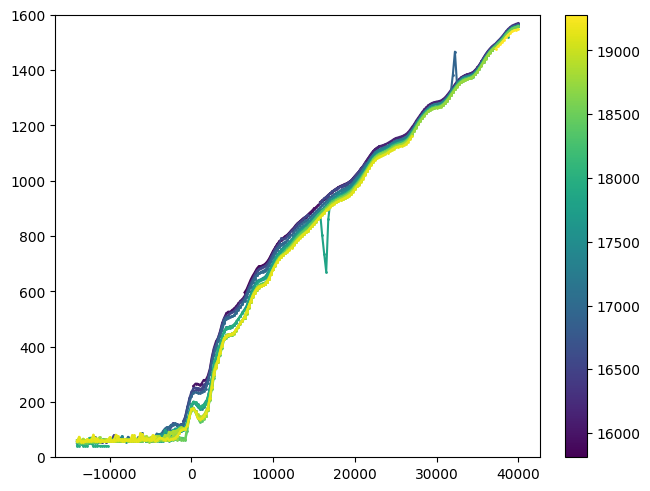

In [97]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.cm import viridis
from matplotlib.colors import Normalize

# fig, ax = plt.subplots(layout="constrained")

# for date in arcticdem_results.date.values:
#     h = arcticdem_results.h_median.sel(date=date).squeeze()

#     ax.plot(arcticdem_results.cd.values, h.values)

# plt.ylim(-200, 2000)
# plt.show()

fig, ax = plt.subplots(layout="constrained")

years = set(arcticdem_results.date.dt.year.values)
date_values = mdates.date2num(arcticdem_results.date.values)
norm = Normalize(vmin=np.min(date_values), vmax=np.max(date_values))
cmap = viridis


for date, date_value in zip(arcticdem_results.date.values, date_values):
    h = arcticdem_results.h_median.sel(date=date).squeeze()

    color_value = norm(date_value)
    color = cmap(color_value)
    ax.plot(arcticdem_results.cd.values, h.values, color=color, marker="o", markersize=1)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)


plt.ylim(0, 1600)
plt.show()

In [117]:
arcticdem_results_2 = xr.open_dataset(
    "../data/elevation/arcticdem/test/ui_data/ui_arcticdem_points.nc"
)
arcticdem_results_2.load()

<xarray.Dataset>
Dimensions:               (cd: 217, date: 57)
Coordinates:
    x                     (cd) float64 5.03e+05 5.027e+05 ... 4.564e+05
    y                     (cd) float64 -2.423e+06 -2.423e+06 ... -2.445e+06
  * cd                    (cd) int64 -14000 -13750 -13500 ... 39500 39750 40000
    glacier_code          (cd) object 'UI' 'UI' 'UI' 'UI' ... 'UI' 'UI' 'UI'
  * date                  (date) datetime64[ns] 2013-04-14T15:00:11 ... 2022-...
    dem_id                (date) object 'SETSM_s2s041_WV02_20130414_103001002...
    valid_area_percent    (date) float64 0.761 0.7296 0.7439 ... 0.9703 0.9041
    aoi_coverage_percent  (date) float64 0.3143 0.3927 ... 0.01758 0.02472
    rmse                  (date) float64 0.4506 0.7094 0.5827 ... 0.2055 0.131
    fileurl               (date) object 'https://data.pgc.umn.edu/elev/dem/se...
    s3url                 (date) object 'https://polargeospatialcenter.github...
Data variables:
    h_median              (cd, date) float64 nan nan nan ... nan nan 1.548e+03

[747.04449463 743.59173584          nan          nan          nan
          nan          nan 738.84399414          nan          nan
          nan 726.43463135          nan 725.12060547          nan
          nan          nan          nan          nan 705.00738525
 704.27093506          nan          nan          nan 701.5824585
          nan 699.98590088          nan          nan          nan
          nan          nan          nan 683.85919189          nan
          nan          nan          nan          nan 683.79754639
          nan          nan          nan          nan 679.40936279
          nan 680.77624512          nan          nan 681.74273682
 679.93634033          nan          nan 679.44128418 679.4152832
          nan          nan]


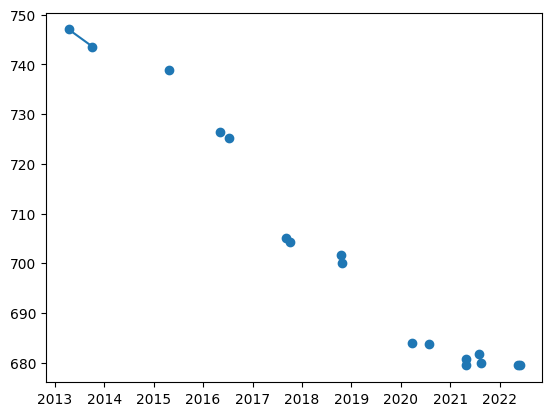

In [113]:
fig, ax = plt.subplots()

sub = arcticdem_results.where(arcticdem_results.cd == 10000, drop=True)
print(sub.h_median.squeeze().values)
ax.plot(sub.date.values, sub.h_median.squeeze().values, marker="o", linestyle="-")

plt.show()

In [41]:
import glob

files = glob.glob("../data/elevation/arcticdem/test/dj_data/*.tif")
files = [f for f in files if f.endswith("coreg_resamp.tif")]
files = sorted(files)[0:20]

arcticdem_results = xr.Dataset(
    data_vars={
        "h_median": (("cd", "date"), np.empty((len(points.cd), len(files)))),
    },
    coords={
        "x": (("cd",), points.geometry.x),
        "y": (("cd",), points.geometry.y),
        "cd": (("cd",), points.cd),
        "glacier_code": (("cd",), points.glacier_code),
    },
)

# Stack mosaics by year into lazy dask dataset
dems = xr.open_mfdataset(files, concat_dim="date", combine="nested")

box_size = 100
half_box = box_size / 2
x_mins = points.geometry.x.values - half_box
x_maxs = points.geometry.x.values + half_box
y_mins = points.geometry.y.values - half_box
y_maxs = points.geometry.y.values + half_box

h_results = []

for i in range(len(points)):
    x_slice = slice(x_mins[i], x_maxs[i])
    y_slice = slice(y_maxs[i], y_mins[i])

    subset = dems.sel(x=x_slice, y=y_slice).squeeze()

    if subset.band_data.size == 0:
        h_median = xr.DataArray(np.nan)
    else:
        h_median = subset.band_data.median(dim=["x", "y"])

    h_results.append(h_median)

    # arcticdem_results["h_median"].loc[dict(cd=point.cd, date=row.acqdate1)] = h_median

arcticdem_results["h_median"] = xr.concat(h_results, dim="cd")

arcticdem_results

<xarray.Dataset>
Dimensions:       (cd: 185, date: 20)
Coordinates:
    x             (cd) float64 5.624e+05 5.621e+05 ... 5.341e+05 5.338e+05
    y             (cd) float64 -1.892e+06 -1.892e+06 ... -1.924e+06 -1.924e+06
  * cd            (cd) int64 -6000 -5750 -5500 -5250 ... 39250 39500 39750 40000
    glacier_code  (cd) object 'DJ' 'DJ' 'DJ' 'DJ' 'DJ' ... 'DJ' 'DJ' 'DJ' 'DJ'
    band          int32 1
    spatial_ref   int32 0
Dimensions without coordinates: date
Data variables:
    h_median      (cd, date) float32 dask.array<chunksize=(1, 20), meta=np.ndarray>

## DJ

In [1]:
"""
This script automatically downloads and coregisters a complete history of ArcticDEM or
REMA strips within a given AOI. The strips will be created within a named directory in 
the current working directory.

The script will download the 2 m ArcticDEM or REMA mosaic for coregistration, and then
loop through the strip record, downloading and coregistering against stable ground
identified within the BedMachine mask.

Note: this will only work in regions of Greenland and Antarctica where bare rock
is exposed. If you require coregistration in other regions, please drop me an email - 
I would be happy to help.

Tom Chudley | thomas.r.chudley@durham.ac.uk
Durham University
November 2023
"""
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pdemtools as pdt
import rioxarray as rxr
import xarray as xr
from rasterio.enums import Resampling

# ----------------------------------------------------------------------------------- #
# EDIT THIS SECTION TO SPECIFY DEPENDENT FILES, THE REGION, AND BOUNDS OF INTEREST
# ----------------------------------------------------------------------------------- #

# Filepath to ArcticDEM parquet file --
# download from https://data.pgc.umn.edu/elev/dem/setsm/ArcticDEM/indexes/ArcticDEM_Strip_Index_latest_gpqt.zip
index_fpath = "../data/elevation/arcticdem/ArcticDEM_Strip_Index_s2s041.parquet"

# Filepath to BedMachine v5 netcdf file
bm_fpath = "../data/misc/bedmachine/BedMachineGreenland-v5.nc"

# The name of your study area - this will be used to name output files and directories
region = "dj"
resolution = 2

# "arcticdem" or "rema"
dataset = "arcticdem"

# the bounds of your study area, in EPSG:3413 for ArcticDEM or EPSG:3031 for REMA

points = gpd.read_file("../data/misc/centreline_points.geojson")
points = points.sort_values(by=["glacier_code", "cd"])
points = points[points["cd"].between(-15000, 40000)]
points = points[points["glacier_code"] == "DJ"].reset_index()

xmin, ymin, xmax, ymax = points.total_bounds


# Parameters with which to filter ArcticDEM dataset. Note that you may wish to add
# more or less - feel free to modify the search function at line 73.
dates = "20000101/20240101"
baseline_max_hours = 48
min_aoi_frac = 0
min_valid_area_pct = 0.50

# ----------------------------------------------------------------------------------- #
# FIND DEMS
# ----------------------------------------------------------------------------------- #

# define AOI
bounds = (xmin, ymin, xmax, ymax)

print(f"Downloading data for {region}:")

# Create output directory
outdir = f"../data/elevation/arcticdem/test/{region}_data"
if not os.path.exists(outdir):
    os.mkdir(outdir)

# Get reference DEM (ArcticDEM mosaic) if it doesn't already exist
reference_dem_fpath = os.path.join(outdir, f"{region}_arcticdem_mosaic_{resolution}m.tif")

if not os.path.exists(reference_dem_fpath):
    print("\nDownloading reference DEM...")

    reference_dem = pdt.load.mosaic(
        dataset=dataset,  # must be `arcticdem` or `rema`
        resolution=resolution,  # must be 2, 10, or 32
        bounds=bounds,  # (xmin, ymin, xmax, ymax) or shapely geometry
        version="v4.1",  # optional: desired version (defaults to most recent)
    )
    reference_dem.rio.to_raster(reference_dem_fpath, compress="ZSTD", predictor=3, zlevel=1)

else:
    print("\nLoading reference DEM...")
    reference_dem = pdt.load.from_fpath(
        os.path.join(outdir, f"{region}_arcticdem_mosaic_{resolution}m.tif"), bounds=bounds
    )

reference_dem = reference_dem.squeeze()
bedrock_mask = pdt.data.bedrock_mask_from_bedmachine(bm_fpath, reference_dem)

# Search for DEM strips
print("\nSearching for DEM strips...")
gdf = pdt.search(
    index_fpath,
    bounds,
    dates=dates,
    # months=[6, 7, 8, 9],
    # years=[2019],
    baseline_max_hours=baseline_max_hours,
    min_aoi_frac=min_aoi_frac,
    min_valid_area_pct=min_valid_area_pct,
)
gdf = gdf.sort_values("acqdate1")

n_strips = len(gdf)
print(f"{n_strips} strips found")


Loading reference DEM...

Searching for DEM strips...
235 strips found


In [2]:
# ----------------------------------------------------------------------------------- #
# PROCESS DEMS
# ----------------------------------------------------------------------------------- #

arcticdem_results = xr.Dataset(
    data_vars={
        "h_median": (("cd", "date"), np.empty((len(points.cd), len(gdf)))),
    },
    coords={
        "x": ("cd", points.geometry.x),
        "y": ("cd", points.geometry.y),
        "cd": ("cd", points.cd),
        "glacier_code": ("cd", points.glacier_code),
        "date": gdf.acqdate1,
        "dem_id": ("date", gdf.dem_id),
        "valid_area_percent": ("date", gdf.valid_area_percent),
        "aoi_coverage_percent": ("date", gdf.aoi_frac),
        "rmse": ("date", gdf.rmse),
        "fileurl": ("date", gdf.fileurl),
        "s3url": ("date", gdf.s3url),
    },
)

i = 0
print("\nDownloading DEM strips...")

for _, row in gdf.iterrows():
    date = row.acqdate1
    date_str = row.acqdate1.date().strftime("%Y%m%d")
    dem_id = row.dem_id

    # centrelines = gpd.read_file("../data/misc/centreline_lines.geojson")
    # centreline_dj = centrelines[centrelines["glacier_code"] == "DJ"].reset_index()
    # valid_area_percent = row.valid_area_percent
    # aoi_frac = row.aoi_frac
    # preview = pdt.load.preview(row, bounds)
    # fig, ax = plt.subplots(layout="constrained")
    # preview.plot(cmap="Greys_r", add_colorbar=False)
    # ax.plot(*centreline_dj.geometry[0].xy, c="red")
    # ax.set_xlim([xmin, xmax])
    # ax.set_ylim([ymin, ymax])
    # plt.title(f"valid-area-%={valid_area_percent:.2f}; aoi-frac={aoi_frac:.2f}")
    # plt.show()

    out_fpath = os.path.join(outdir, f"{date_str}_{dem_id}_coreg_resamp.tif")

    dem = pdt.load.from_search(row, bounds=bounds, bitmask=True)
    dem = dem.rio.pad_box(*bounds, constant_values=np.nan)
    dem = dem.pdt.coregister(reference_dem, bedrock_mask, max_horiz_offset=50)

    downscale_factor = 2 / 20
    new_width = int(dem.rio.width * downscale_factor)
    new_height = int(dem.rio.height * downscale_factor)
    dem = dem.rio.reproject(
        dem.rio.crs,
        shape=(new_height, new_width),
        resampling=Resampling.bilinear,
    )

    box_size = 100
    half_box = box_size / 2
    x_mins = points.geometry.x.values - half_box
    x_maxs = points.geometry.x.values + half_box
    y_mins = points.geometry.y.values - half_box
    y_maxs = points.geometry.y.values + half_box

    for j, point in points.iterrows():
        x_slice = slice(x_mins[j], x_maxs[j])
        y_slice = slice(y_maxs[j], y_mins[j])

        subset = dem.sel(x=x_slice, y=y_slice)

        h_median = subset.median(dim=["x", "y"])
        h_median = h_median.assign_coords(
            cd=point.cd,
            glacier_code=point.glacier_code,
        )

        arcticdem_results["h_median"].loc[dict(cd=point.cd, date=row.acqdate1)] = h_median

    if not os.path.exists(out_fpath):
        print(f"\nSaving {i}/{n_strips} {os.path.basename(out_fpath)}...")
        dem.rio.to_raster(out_fpath, compress="ZSTD", predictor=3, zlevel=1)

    del dem

    i += 1

arcticdem_results.to_netcdf(
    "../data/elevation/arcticdem/test/dj_data/dj_arcticdem_points-3.nc"
)
print("Finished")

C:\Users\olive\AppData\Local\Temp\ipykernel_19752\1384362099.py:5: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  arcticdem_results = xr.Dataset(



Planimetric Correction Iteration 1
Offset (z,x,y): 0.000, 0.000, 0.000
RMSE = 5.53987455368042
Planimetric Correction Iteration 2
Offset (z,x,y): 4.994, 0.523, -8.075
Translating: 4.99 Z, 0.52 X, -8.07 Y
RMSE = 2.2097067832946777
Planimetric Correction Iteration 3
Offset (z,x,y): 4.973, 0.835, -7.830
Translating: 4.97 Z, 0.83 X, -7.83 Y
RMSE = 2.1770412921905518
Planimetric Correction Iteration 4
Offset (z,x,y): 4.947, 0.860, -7.823
Translating: 4.95 Z, 0.86 X, -7.82 Y
RMSE = 2.1754183769226074
Planimetric Correction Iteration 5
Offset (z,x,y): 4.946, 0.862, -7.823
Translating: 4.95 Z, 0.86 X, -7.82 Y
RMSE = 2.1753506660461426
RMSE step in this iteration (-0.00007) is above threshold (-0.001), stopping and returning values of prior iteration. 
Final offset (z,x,y): 4.947, 0.860, -7.823
Final RMSE = 2.1754183769226074
Planimetric Correction Iteration 1
Offset (z,x,y): 0.000, 0.000, 0.000
RMSE = 2.956359624862671
Planimetric Correction Iteration 2
Offset (z,x,y): -2.213, 4.732, -5.268
T

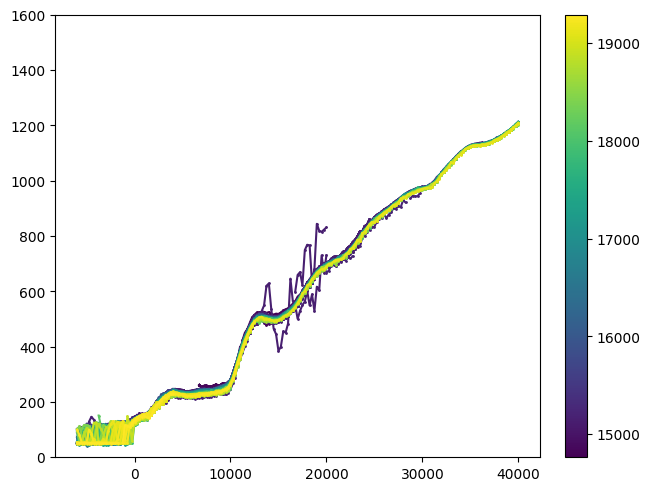

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.cm import viridis
from matplotlib.colors import Normalize

fig, ax = plt.subplots(layout="constrained")

years = set(arcticdem_results.date.dt.year.values)
date_values = mdates.date2num(arcticdem_results.date.values)
norm = Normalize(vmin=np.min(date_values), vmax=np.max(date_values))
cmap = viridis


for date, date_value in zip(arcticdem_results.date.values, date_values):
    h = arcticdem_results.h_median.sel(date=date).squeeze()

    color_value = norm(date_value)
    color = cmap(color_value)
    ax.plot(arcticdem_results.cd.values, h.values, color=color, marker="o", markersize=1)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)


plt.ylim(0, 1600)
plt.show()

NameError: name 'arcticdem_results' is not defined

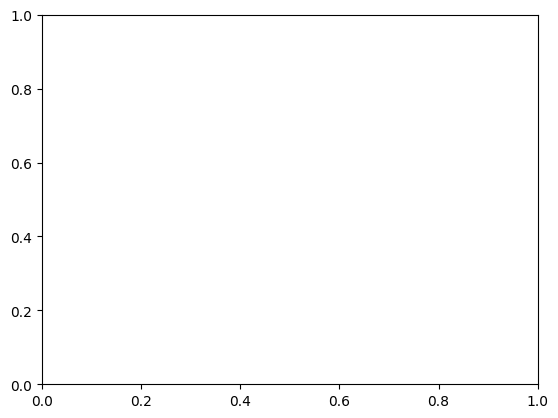

In [49]:
fig, ax = plt.subplots()

sub = arcticdem_results.where(arcticdem_results.cd == 250, drop=True)
print(sub.h_median.squeeze().values)
ax.plot(sub.date.values, sub.h_median.squeeze().values, marker="o", linestyle="-")

plt.show()